In [ ]:
!pip install python-pptx

     ---------------------------------------- 0.0/471.6 kB ? eta -:--:--
     ----- --------------------------------- 61.4/471.6 kB 1.7 MB/s eta 0:00:01
     ---------------------------------- --- 430.1/471.6 kB 5.4 MB/s eta 0:00:01
     -------------------------------------- 471.6/471.6 kB 4.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/154.8 kB ? eta -:--:--
     -------------------------------------- 154.8/154.8 kB 9.0 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [2]:
import pandas as pd

# Load the data from the uploaded file
#file_path = r'E:\Root\Chmoinformatics\표면휘발식\2023 ODE\B9A28580.xlsx'
file_path = '/content/drive/MyDrive/ODE/B9A28580.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet4')

# Display the first few rows of the data
data.head()

,time(min),time(hr),BKC amount (ug/m3),BKC amount (mg/m3),Unnamed: 4,Sample info:front_manual
0,1,0.016667,NaN,0.000000,NaN,NaN
1,2,0.033333,11.920344,0.011920,NaN,NaN
2,3,0.050000,16.106685,0.016107,NaN,NaN
3,4,0.066667,19.101148,0.019101,NaN,NaN
4,5,0.083333,19.439403,0.019439,NaN,NaN


In [3]:
# Load some sheets in the Excel file
data = pd.read_excel(file_path, sheet_name=None)

#use for loop to print all sheet data
for sheet in data:
    print(sheet)
    print(data[sheet].head())
    print()

Sheet2
   time(min)  time(hr)  BKC amount (ug/m3)  BKC amount (mg/m3)  Unnamed: 4  \
0          1  0.016667                 NaN            0.000000         NaN   
1          2  0.033333          594.280055            0.594280         NaN   
2          3  0.050000          950.687744            0.950688         NaN   
3          4  0.066667         1293.583958            1.293584         NaN   
4          5  0.083333         1420.571980            1.420572         NaN   

   Sample info:front_auto  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  

Sheet3
   time(min)  time(hr)  BKC amount (ug/m3)  BKC amount (mg/m3)  Unnamed: 4  \
0          1  0.016667                 NaN            0.000000         NaN   
1          2  0.033333          170.529774            0.170530         NaN   
2          3  0.050000          377.755939            0.377756         NaN   
3          4  0.066667          511.

(29.073855244245454, 14.837604328431203, 0.08333333333333333) 0.09762774337723837
Sample info:front_auto
front_auto


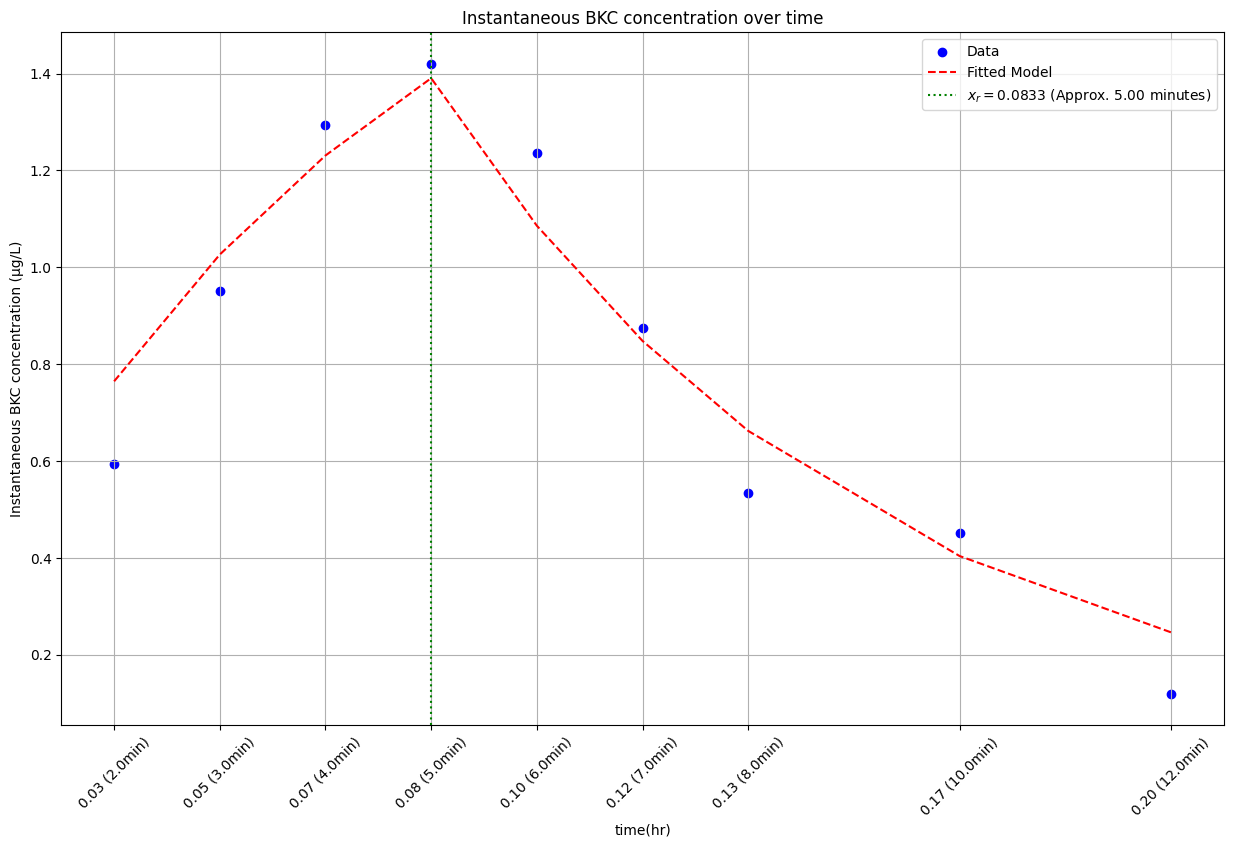

(16.116625052093898, 36.040303072216844, 0.0776094276094276) 0.03618425507805262
Sample info:back_auto
back_auto


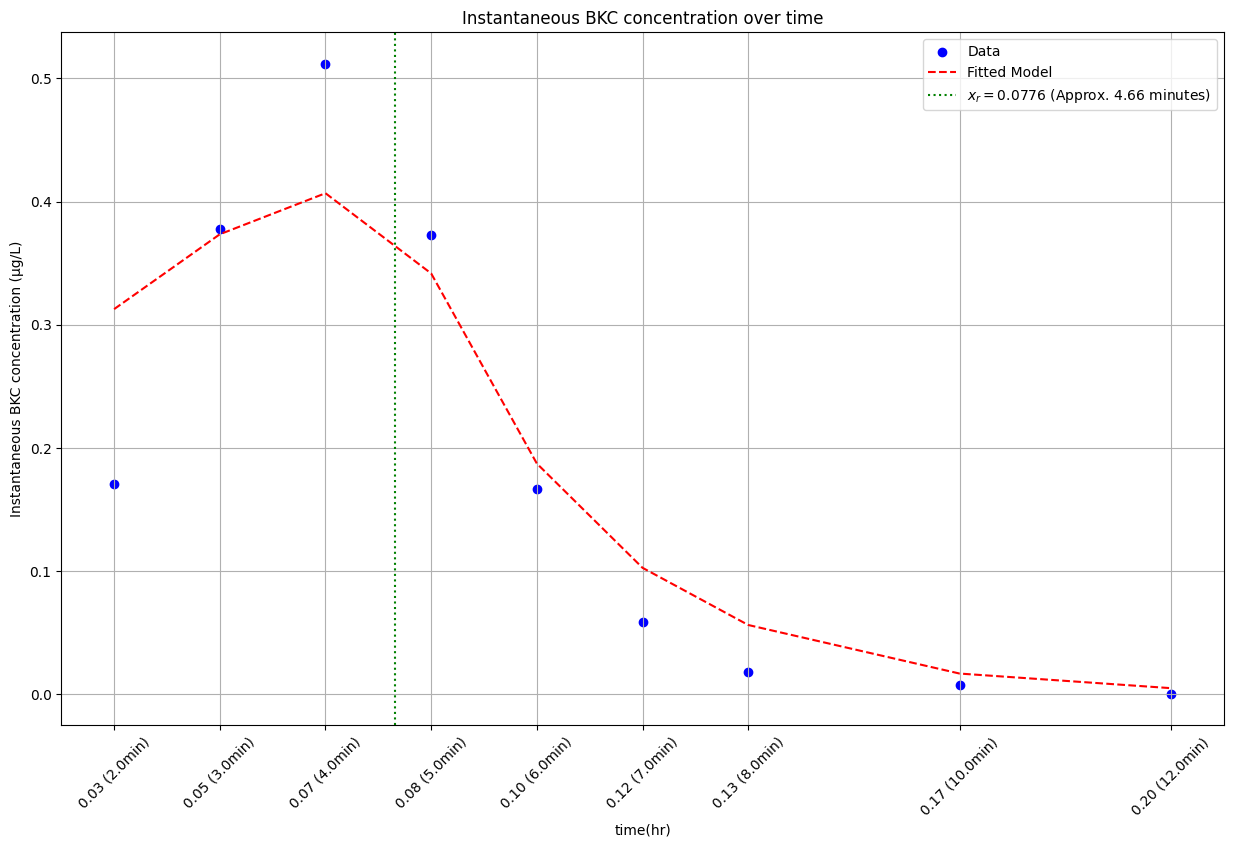

(0.43330429382497837, 12.94328497329173, 0.07794612794612794) 1.0196879449508167e-05
Sample info:front_manual
front_manual


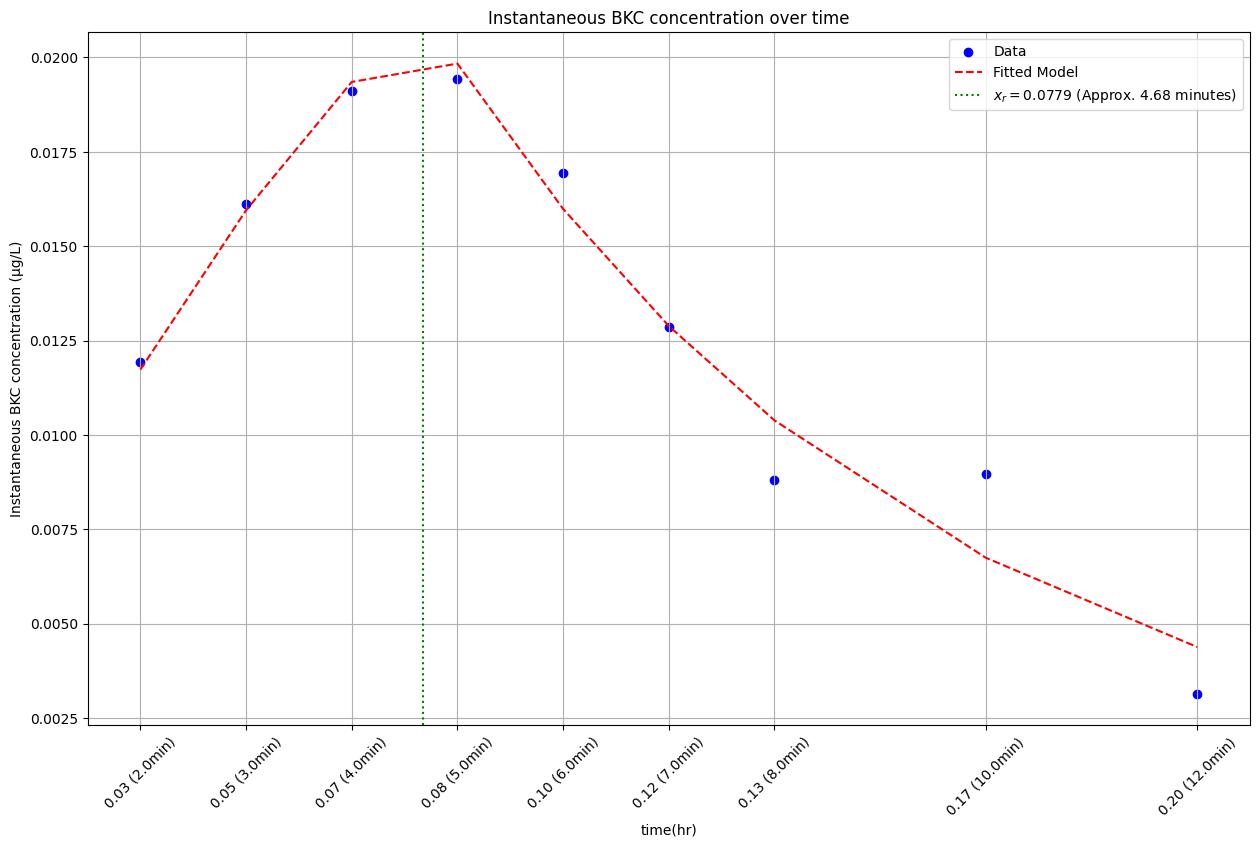

(0.9357171896621786, 12.49676347961491, 0.08333333333333333) 0.00015908860453685882
Sample info:back_manual
back_manual


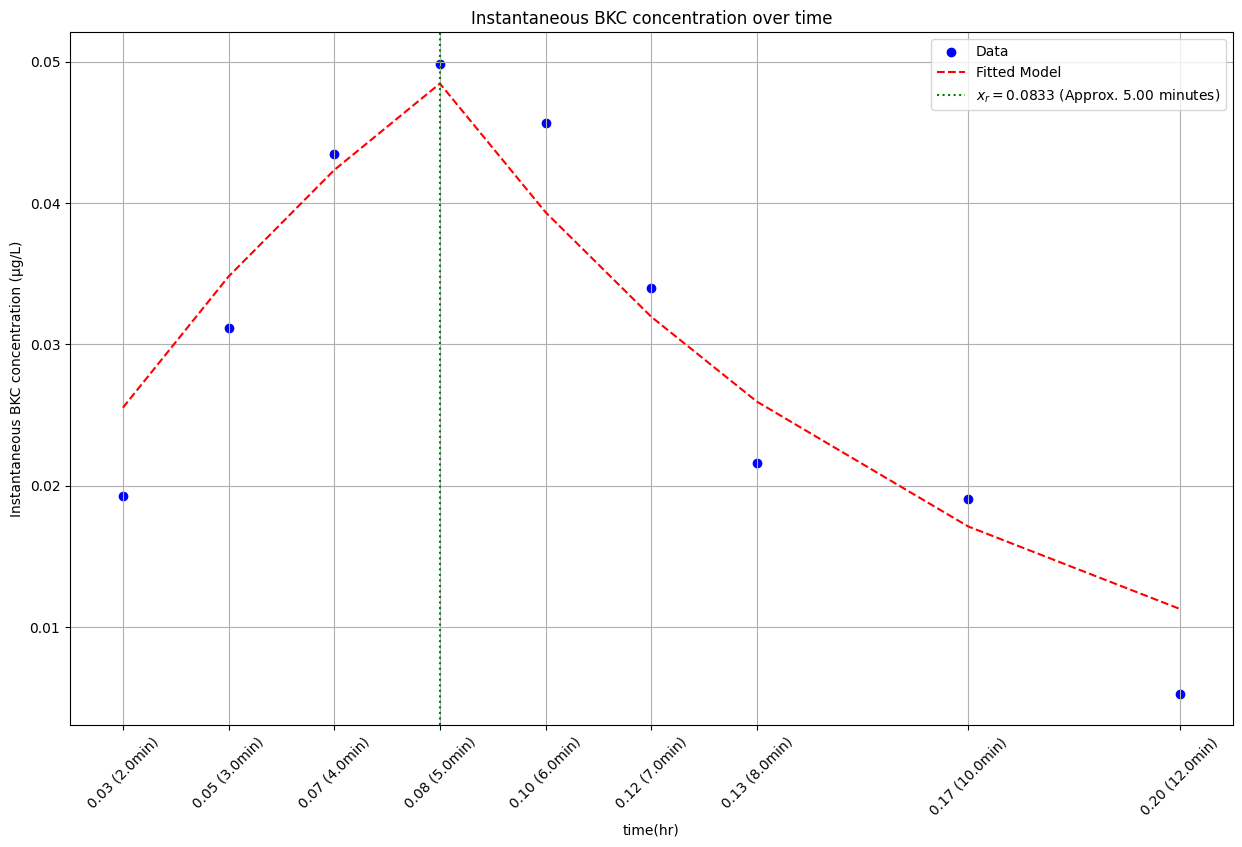

In [7]:
# from pptx import Presentation
# from pptx.util import Inches, Pt
# from pptx.enum.text import PP_ALIGN

# Create a presentation object
# prs = Presentation()

# Add a slide with a title and content layout
# slide_layout = prs.slide_layouts[6]


Rs_list = [760/4, 570/4, 1250/4, 880/4]

Vs_list = []

Fair_list = []

ρdv_list = []

ρdv_re_list = []

R_sq_list = []

SSE_list = []

A_list = []

B_list = []

xr_list = []
# xr = 4/60

# 특정 column만 불러오기
# BKC back만
for i, sheet in enumerate(data):
    data_bkc_back = data[sheet][['time(hr)', 'BKC amount (ug/m3)']] # BKC amount -back (raw)

    # 결측치 제거
    data_bkc_back = data_bkc_back.dropna()

    import numpy as np
    from scipy.optimize import curve_fit

    # Extracting the relevant data
    x_data = data_bkc_back['time(hr)'].values
    y_data = (data_bkc_back['BKC amount (ug/m3)'].values)/1000

    # Define the piecewise function
    def piecewise_func_back(x, a, b, xr):
        return np.where(x <= xr,
                        (a/b) * (1 - np.exp(-b * x)),
                        (a/b) * ((1 - np.exp(-b * xr)) * np.exp(-b * (x - xr))))

    # Initialize best fit parameters and the corresponding error
    best_params = None
    lowest_error = float('inf')

    # Iterate over a range of possible xr values
    for xr in np.linspace(4/60, 5/60, 100):  # Fine-grained search within the interval
        try:
            # Fit the model to the data
            params, _ = curve_fit(lambda x, a, b: piecewise_func_back(x, a, b, xr), x_data, y_data, p0=[1, 1])

            # Calculate the sum of squared errors
            fitted_values = piecewise_func_back(x_data, params[0], params[1], xr)
            error = np.sum((y_data - fitted_values) ** 2)

            # Update best parameters if this fit is better
            if error < lowest_error:
                best_params = (params[0], params[1], xr)
                lowest_error = error
        except RuntimeError:
            # In case the fitting fails for a specific set of parameters
            continue

    # Best parameters and the corresponding error
    print(best_params, lowest_error)
    # Unpack the updated best parameters
    a_best, b_best, xr_best = best_params

    A_list.append(a_best)
    B_list.append(b_best)
    xr_list.append(xr_best*60)

    # Generate fitted values with updated parameters
    fitted_y = piecewise_func_back(x_data, a_best, b_best, xr_best)

    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # Calculate RMSE, MAE, and R²
    rmse_back = np.sqrt(mean_squared_error(y_data, fitted_y))
    mae_back = mean_absolute_error(y_data, fitted_y)
    r_squared = r2_score(y_data, fitted_y)

    # Sum of Squared Errors (SSE) is already calculated as lowest_error_updated
    sse = lowest_error

    R_sq_list.append(r_squared)
    SSE_list.append(sse)

    # Print the results

    # 맨 마지막 column name 불러오기
    print(data[sheet].columns[-1])

    # 맨 마지막 column name을 :로 split
    split_name_back = data[sheet].columns[-1].split(':')
    print(split_name_back[-1])

    # Plotting with updated fit
    plt.figure(figsize=(15, 9))
    plt.scatter(x_data, y_data, label='Data', color='blue')
    plt.plot(x_data, fitted_y, label='Fitted Model', color='red', linestyle='--')
    xticks_labels = [f'{hour:.2f} ({hour*60}min)' for hour in x_data]
    plt.xticks(x_data, xticks_labels, rotation=45)
    plt.axvline(x=xr_best, color='green', linestyle=':', label=f'$x_r = {xr_best:.4f}$ (Approx. {xr_best*60:.2f} minutes)')

    plt.title('Instantaneous BKC concentration over time') # 샘플 이름으로 변경
    plt.xlabel('time(hr)')
    plt.ylabel('Instantaneous BKC concentration (μg/L)')
    plt.legend()


    # Split the fitted equation string into multiple lines
    fitted_equation_lines = [
        f"Fitted Equation:",
        f"y = a/b(1-e^(-bx)) for x <= xr",
        f"y = a/b(1-e^(-bxr))e^(-b(x-xr)) for x > xr",
        f"where a = {a_best:.2f}, b = {b_best:.2f}"
    ]

    figure_of_merit = [
        f"Figure_of_merit:",
        f"Coefficient of Determination (R²) = {r_squared:.2f}",
        f"Sum of Squared Errors (SSE) = {sse:.2f}"
    ]

    N = 0.66
    h = 1.5

    Vs = (b_best - N) * h # 빈 리스트 만들고 append
    Vs_list.append(Vs)

    ρdv = (Vs*18*0.0181)/(3600*9.8)
    ρdv_list.append(ρdv)

    ρdv_re = ρdv * 10 ** 4
    ρdv_re_list.append(ρdv_re)

    V = 105
    wf = 500 / 1000000
    Rs = ((Rs_list[i]*4)/(xr_best*60)) * (60*1000)

    Fair = (a_best * V) / (Rs * wf) # 빈 리스트 만들고 append
    Fair_list.append(Fair)

    value_back = [
        f"Value of Vs and Fair:",
        f"Vs = {Vs:.2f} m/hr",
        f"Fair = {Fair:.4f}",
        f"ρdv^2 = {ρdv_re:.4f}*10^(-4) g/m^3 * m^2"
    ]



    #Position the text in the upper right corner, below the legend
    # plt.text(0.63, 0.68, '\n'.join(fitted_equation_lines_back), fontsize=9,
    #         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    # plt.text(0.63, 0.55, '\n'.join(figure_of_merit_back), fontsize=9,
    #         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    # plt.text(0.63, 0.42, '\n'.join(value_back), fontsize=9,
    #         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.grid(True)
    #파일명을 split_name_back으로 변경
    #plt.savefig(r"E:\Root\Chmoinformatics\표면휘발식\2023 ODE" + "/" + "{}_240124.png".format(str(split_name_back[-1])), dpi=300)
    plt.show()

    #slide_back = prs.slides.add_slide(slide_layout)

    fitted_equation_lines_txt = [
        "Fitted Equation:",
        "y = a/b(1-e^(-bx)) for x <= xr",
        "y = a/b(1-e^(-bxr))e^(-b(x-xr)) for x > xr",
        f"where a = {a_best:.2f}, b = {b_best:.2f}",
        "",
        "Figure of merit:",
        f"Coefficient of Determination (R²) = {r_squared:.2f}",
        f"Sum of Squared Errors (SSE) = {sse:.2f}",
        "",
        "Value of Vs, Fair and ρdv^2 :",
        f"Vs = {Vs:.2f} m/hr",
        f"Fair = {Fair:.4f}",
        f"ρdv^2 = {ρdv_re:.4f}*10^(-4) g/m^3 * m^2"
    ]

    fitted_equation_text = "\n".join(fitted_equation_lines_txt)

    # Add a text box for the fitted equation text
    # left, top, width, height = Inches(0.5), Inches(1), Inches(4), Inches(3)
    # txBox = slide_back.shapes.add_textbox(left, top, width, height)
    # tf = txBox.text_frame
    # tf.text = fitted_equation_lines_txt[0]  # Set the first line of text

    # Add the remaining lines
    # for line in fitted_equation_lines_txt[1:]:
    #     p = tf.add_paragraph()
    #     p.text = line
    #     p.font.size = Pt(12)
    #     p.alignment = PP_ALIGN.LEFT

    #     if line.startswith("Figure"):
    #         p.font.size = Pt(18)
    #     elif line.startswith("Value"):
    #         p.font.size = Pt(18)

    # # Insert the plot image
    # img_path_back = r"E:\Root\Chmoinformatics\표면휘발식\2023 ODE" + "/" + "{}_240124.png".format(str(split_name_back[-1]))
    # left_img, top_img, width_img, height_img = Inches(3.5), Inches(0.8), Inches(5), Inches(4)
    # pic = slide_back.shapes.add_picture(img_path_back, left_img, top_img, height=height)

Vs_avg = sum(Vs_list) / len(Vs_list)
Fair_avg = sum(Fair_list) / len(Fair_list)
ρdv_avg = sum(ρdv_list) / len(ρdv_list)
ρdv_re_avg = sum(ρdv_re_list) / len(ρdv_re_list)

# Add a slide and insert the average value of Vs and Fair
# slide_layout_avg = prs.slide_layouts[6]
# slide_avg = prs.slides.add_slide(slide_layout_avg)

fitted_equation_lines_txt_avg = [
    "Average value of Vs and Fair:",
    f"Vs = {Vs_avg:.2f} m/hr",
    f"Fair = {Fair_avg:.4f}",
    f"ρdv^2 = {ρdv_re_avg:.4f}*10^(-4) g/m^3 * m^2"
]

fitted_equation_text_avg = "\n".join(fitted_equation_lines_txt_avg)

# Add a text box for the fitted equation text

# left, top, width, height = Inches(0.5), Inches(1), Inches(4), Inches(3)
# txBox = slide_avg.shapes.add_textbox(left, top, width, height)
# tf = txBox.text_frame
# tf.text = fitted_equation_lines_txt_avg[0]  # Set the first line of text

# Add the remaining lines
# for line in fitted_equation_lines_txt_avg[1:]:
#     p = tf.add_paragraph()
#     p.text = line
#     p.font.size = Pt(12)
#     p.alignment = PP_ALIGN.LEFT

# prs.save(r"E:\Root\Chmoinformatics\표면휘발식\2023 ODE\bkc_ODE_240124.pptx")


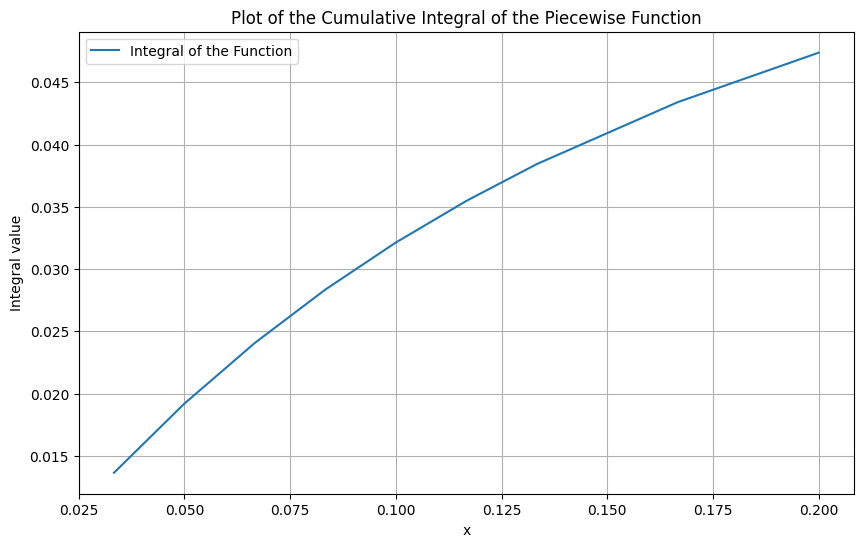

In [18]:
from scipy.integrate import quad

# Integration parameters
A = A_list[-1]  # Example value, can be changed
b = B_list[-1]  # Example value, can be changed
xr = xr_list[-1]  # Example value, can be changed
#x_lower = x_data[0]  # Lower limit of integration
#x_upper = x_data[-1]  # Upper limit of integration

# Perform the integration

integral_values = [(quad(piecewise_func_back, 0, x, args=(A, b, xr))[0])/x for x in x_data]

plt.figure(figsize=(10, 6))
plt.plot(x_data, integral_values, label='Integral of the Function')
plt.xlabel('x')
plt.ylabel('Integral value')
plt.title('Plot of the Cumulative Integral of the Piecewise Function')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#list들을 dataframe으로 만들기
df_Vs = pd.DataFrame(Vs_list)
df_Fair = pd.DataFrame(Fair_list)
df_ρdv = pd.DataFrame(ρdv_list)
df_Rs = pd.DataFrame(Rs_list)
df_R_sq = pd.DataFrame(R_sq_list)
df_SSE = pd.DataFrame(SSE_list)
df_A = pd.DataFrame(A_list)
df_B = pd.DataFrame(B_list)
df_xr = pd.DataFrame(xr_list)

#dataframe 합치기
df_values = pd.concat([df_Vs, df_Fair, df_ρdv, df_Rs, df_R_sq, df_SSE, df_A, df_B, df_xr], axis=1)
df_values.columns = ['Vs', 'Fair', 'ρdv', 'Rs', 'R-square', 'SSE', 'A', 'B', 'xr']
df_values.index = ['BKC front auto', 'BKC back auto', 'BKC front manual', 'BKC back manual']

df_values.to_csv('/content/drive/MyDrive/ODE/bkc_ODE_values_240521.csv')
df_values

,Vs,Fair,ρdv,Rs,R-square,SSE,A,B,xr
BKC front auto,21.266406,0.669464,0.000196,190.0,0.936439,0.097628,29.073855,14.837604,5.000000
BKC back auto,53.070455,0.460822,0.000490,142.5,0.874808,0.036184,16.116625,36.040303,4.656566
BKC front manual,18.424927,0.005674,0.000170,312.5,0.956773,0.000010,0.433304,12.943285,4.676768
BKC back manual,17.755145,0.018608,0.000164,220.0,0.909414,0.000159,0.935717,12.496763,5.000000


(40.528409344567535, 19.685661326464054, 0.08333333333333333) 6.410176415402362
Sample info:back1
back1


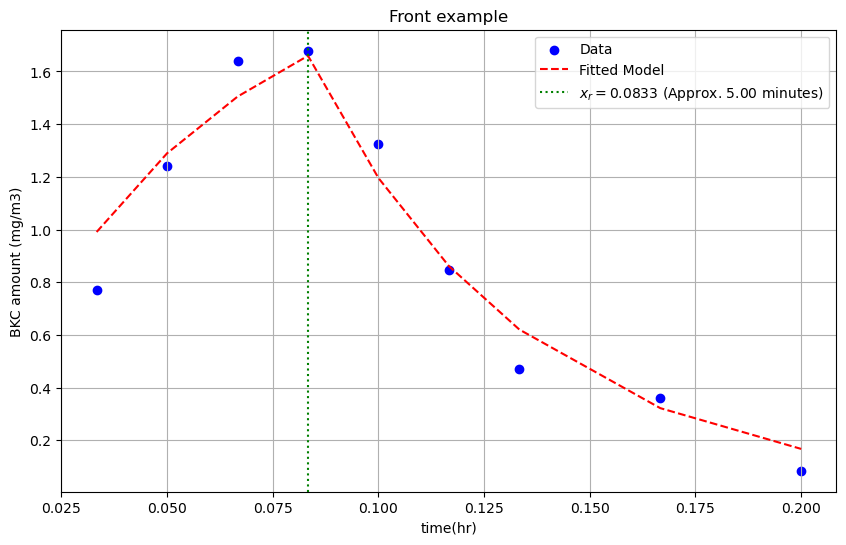

(40.528409344567535, 19.685661326464054, 0.08333333333333333) 6.410176415402362
Sample info:back2
back2


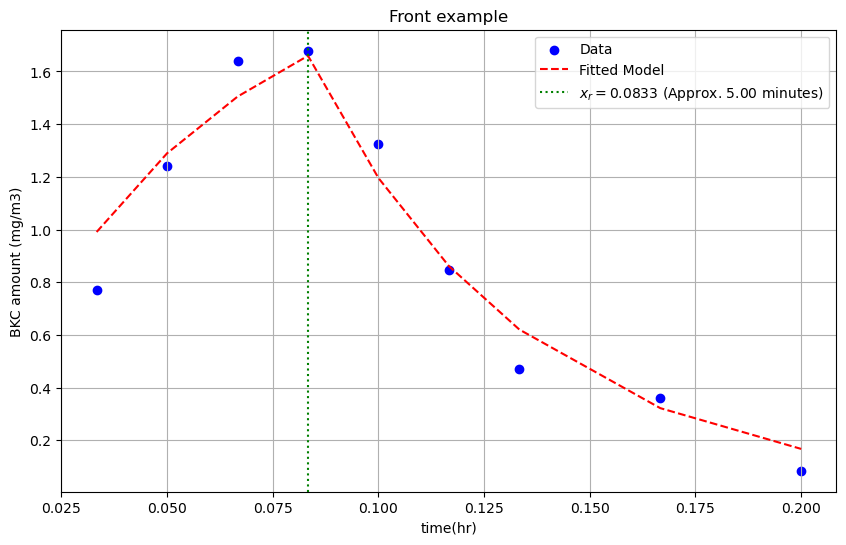

In [ ]:
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN

# Create a presentation object
prs_front = Presentation()

# Add a slide with a title and content layout
slide_layout_front = prs_front.slide_layouts[6]

Vs_front_list = []

Fair_front_list = []

# 특정 column만 불러오기
# BKC back만
for sheet in data:
    data_bkc_front = data[sheet][['time(hr)', 'BKC amount -front- (ug/m3)', 'BKC amount -front- (mg/m3)']] # BKC amount -back (raw)

    # 결측치 제거
    data_bkc_front = data_bkc_front.dropna()

    import numpy as np
    from scipy.optimize import curve_fit

    # Extracting the relevant data
    x_data_front = data_bkc_front['time(hr)'].values
    y_data_front = data_bkc_front['BKC amount -front- (mg/m3)'].values

    # Define the piecewise function
    def piecewise_func_front(x, a, b, xr):
        return np.where(x <= xr,
                        (a/b) * (1 - np.exp(-b * x)),
                        (a/b) * ((1 - np.exp(-b * xr)) * np.exp(-b * (x - xr))))

    # Initialize best fit parameters and the corresponding error
    best_params_front = None
    lowest_error_front = float('inf')

    # Iterate over a range of possible xr values
    for xr_front in np.linspace(4/60, 5/60, 100):  # Fine-grained search within the interval
        try:
            # Fit the model to the data
            params_front, _ = curve_fit(lambda x, a, b: piecewise_func_back(x, a, b, xr_front), x_data_front, y_data_front, p0=[1, 1])

            # Calculate the sum of squared errors
            fitted_values_front = piecewise_func_back(x_data_front, params[0], params[1], xr_front)
            error_front = np.sum((y_data_front - fitted_values_front) ** 2)

            # Update best parameters if this fit is better
            if error_front < lowest_error_front:
                best_params_front = (params_front[0], params_front[1], xr_front)
                lowest_error_front = error_front
        except RuntimeError:
            # In case the fitting fails for a specific set of parameters
            continue

    # Best parameters and the corresponding error
    print(best_params_front, lowest_error_front)
    # Unpack the updated best parameters
    a_best_front, b_best_front, xr_best_front = best_params_front

    # Generate fitted values with updated parameters
    fitted_y_front = piecewise_func_front(x_data_front, a_best_front, b_best_front, xr_best_front)

    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # Calculate RMSE, MAE, and R²
    rmse_front = np.sqrt(mean_squared_error(y_data_front, fitted_y_front))
    mae_front = mean_absolute_error(y_data_front, fitted_y_front)
    r_squared_front = r2_score(y_data_front, fitted_y_front)

    # Sum of Squared Errors (SSE) is already calculated as lowest_error_updated
    sse_front = lowest_error_front

    # Plotting with updated fit
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data_front, y_data_front, label='Data', color='blue')
    plt.plot(x_data_front, fitted_y_front, label='Fitted Model', color='red', linestyle='--')
    plt.axvline(x=xr_best_front, color='green', linestyle=':', label=f'$x_r = {xr_best_front:.4f}$ (Approx. {xr_best_front*60:.2f} minutes)')

    plt.title('Front example') # 샘플 이름으로 변경
    plt.xlabel('time(hr)')
    plt.ylabel('BKC amount (mg/m3)')
    plt.legend()

    # Split the fitted equation string into multiple lines
    fitted_equation_lines_front = [
        f"Fitted Equation:",
        f"y = a/b(1-e^(-bx)) for x <= xr",
        f"y = a/b(1-e^(-bxr))e^(-b(x-xr)) for x > xr",
        f"where a = {a_best_front:.2f}, b = {b_best_front:.2f}"
    ]

    figure_of_merit_front = [
        f"Figure_of_merit:",
        f"Coefficient of Determination (R²) = {r_squared_front:.2f}",
        f"Sum of Squared Errors (SSE) = {sse_front:.2f}"
    ]

    N = 0.66
    h = 1.5

    Vs_front = (b_best_front - N) * h # 빈 리스트 만들고 append
    Vs_front_list.append(Vs_front)

    V = 105
    wf = 500 * 1000000
    Rs = (570/4) / (60*1000)

    Fair_front = (a_best_front * V) / (Rs * wf) # 빈 리스트 만들고 append
    Fair_front_list.append(Fair_front)

    value_front = [
        f"Value of Vs and Fair:",
        f"Vs = {Vs_front:.2f} m/hr",
        f"Fair = {Fair_front:.4f}"
    ]

    # 맨 마지막 column name 불러오기
    print(data[sheet].columns[-1])

    # 맨 마지막 column name을 :로 split
    split_name_front = data[sheet].columns[-1].split(':')
    print(split_name_front[-1])

    #Position the text in the upper right corner, below the legend
    # plt.text(0.63, 0.68, '\n'.join(fitted_equation_lines_back), fontsize=9,
    #         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    # plt.text(0.63, 0.55, '\n'.join(figure_of_merit_back), fontsize=9,
    #         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    # plt.text(0.63, 0.42, '\n'.join(value_back), fontsize=9,
    #         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.grid(True)
    #파일명을 split_name_back으로 변경
    plt.savefig(r"E:\Root\Chmoinformatics\표면휘발식\2023 ODE\BKC_front" + "/" + "{}.png".format(str(split_name_front[-1])), dpi=300)
    plt.show()

    slide_front = prs_front.slides.add_slide(slide_layout_front)

    fitted_equation_lines_txt_front = [
        "Fitted Equation:",
        "y = a/b(1-e^(-bx)) for x <= xr",
        "y = a/b(1-e^(-bxr))e^(-b(x-xr)) for x > xr",
        f"where a = {a_best_front:.2f}, b = {b_best_front:.2f}",
        "",
        "Figure of merit:",
        f"Coefficient of Determination (R²) = {r_squared_front:.2f}",
        f"Sum of Squared Errors (SSE) = {sse_front:.2f}",
        "",
        "Value of Vs and Fair:",
        f"Vs = {Vs_front:.2f} m/hr",
        f"Fair = {Fair_front:.4f}"
    ]

    fitted_equation_text_front = "\n".join(fitted_equation_lines_txt_front)

    # Add a text box for the fitted equation text
    left, top, width, height = Inches(0.5), Inches(1), Inches(4), Inches(3)
    txBox = slide_front.shapes.add_textbox(left, top, width, height)
    tf = txBox.text_frame
    tf.text = fitted_equation_lines_txt_front[0]  # Set the first line of text

    # Add the remaining lines
    for line in fitted_equation_lines_txt_front[1:]:
        p = tf.add_paragraph()
        p.text = line
        p.font.size = Pt(12)
        p.alignment = PP_ALIGN.LEFT

        if line.startswith("Figure"):
            p.font.size = Pt(18)
        elif line.startswith("Value"):
            p.font.size = Pt(18)



    # Insert the plot image
    img_path = r"E:\Root\Chmoinformatics\표면휘발식\2023 ODE\BKC_front" + "/" + "{}.png".format(str(split_name_back[-1]))
    left_img, top_img, width_img, height_img = Inches(3.5), Inches(0.8), Inches(5), Inches(4)
    pic = slide_front.shapes.add_picture(img_path, left_img, top_img, height=height)

Vs_front_avg = sum(Vs_front_list) / len(Vs_front_list)
Fair_front_avg = sum(Fair_front_list) / len(Fair_front_list)

# Add a slide and insert the average value of Vs and Fair
slide_layout_front_avg = prs_front.slide_layouts[6]
slide_front_avg = prs_front.slides.add_slide(slide_layout_front_avg)

fitted_equation_lines_txt_front_avg = [
    "Average value of Vs and Fair:",
    f"Vs = {Vs_front_avg:.2f} m/hr",
    f"Fair = {Fair_front_avg:.4f}"
]

fitted_equation_text_front_avg = "\n".join(fitted_equation_lines_txt_front_avg)

# Add a text box for the fitted equation text

left, top, width, height = Inches(0.5), Inches(1), Inches(4), Inches(3)
txBox = slide_front_avg.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.text = fitted_equation_lines_txt_front_avg[0]  # Set the first line of text

# Add the remaining lines
for line in fitted_equation_lines_txt_front_avg[1:]:
    p = tf.add_paragraph()
    p.text = line
    p.font.size = Pt(12)
    p.alignment = PP_ALIGN.LEFT

prs_front.save(r"E:\Root\Chmoinformatics\표면휘발식\2023 ODE\BKC_front\bkc_front_example.pptx")


In [ ]:
data_bkc_front = pd.read_excel(file_path, sheet_name='Sheet1', usecols='B, G, H')
data_bkc_front = data_bkc_front.dropna()
data_bkc_front


,time(hr),BKC amount -front- (ug/m3),BKC amount -front- (mg/m3)
1,0.033333,769.800143,0.769800
2,0.050000,1241.213146,1.241213
3,0.066667,1640.138025,1.640138
4,0.083333,1678.778566,1.678779
5,0.100000,1323.991903,1.323992
6,0.116667,845.565063,0.845565
7,0.133333,469.575036,0.469575
8,0.166667,359.065021,0.359065
9,0.200000,84.152373,0.084152


In [ ]:
# Extracting the relevant data
x_data = data_bkc_back['time(hr)'].values
y_data = data_bkc_back['BKC amount -back (mg/m3)'].values

# Define the piecewise function
def piecewise_func(x, a, b, xr):
    return np.where(x <= xr,
                    (a/b) * (1 - np.exp(-b * x)),
                    (a/b) * ((1 - np.exp(-b * xr)) * np.exp(-b * (x - xr))))

# Initialize best fit parameters and the corresponding error
best_params = None
lowest_error = float('inf')

# Iterate over a range of possible xr values
for xr in np.linspace(4/60, 5/60, 100):  # Fine-grained search within the interval
    try:
        # Fit the model to the data
        params, _ = curve_fit(lambda x, a, b: piecewise_func(x, a, b, xr), x_data, y_data, p0=[1, 1])

        # Calculate the sum of squared errors
        fitted_values = piecewise_func(x_data, params[0], params[1], xr)
        error = np.sum((y_data - fitted_values) ** 2)

        # Update best parameters if this fit is better
        if error < lowest_error:
            best_params = (params[0], params[1], xr)
            lowest_error = error
    except RuntimeError:
        # In case the fitting fails for a specific set of parameters
        continue

# Best parameters and the corresponding error
best_params, lowest_error

((16.116625052093898, 36.040303072216844, 0.0776094276094276),
 0.03618425507805262)

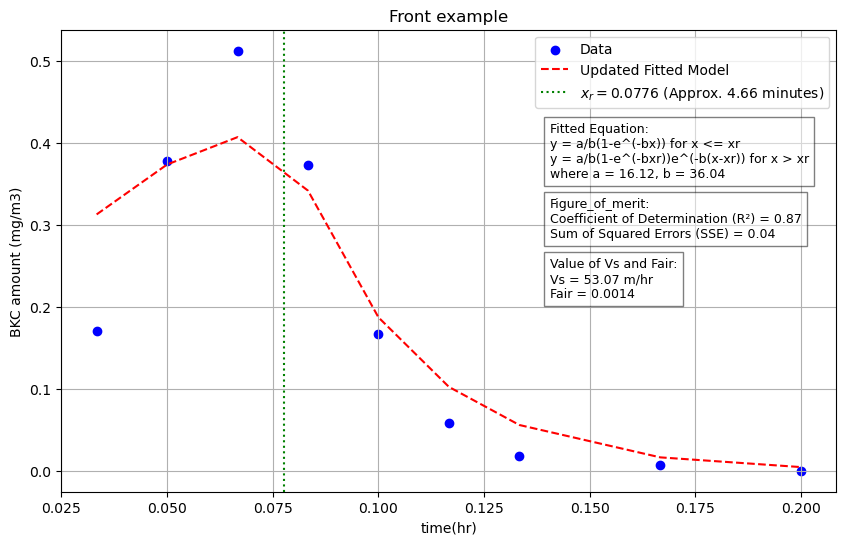

In [ ]:
# Unpack the updated best parameters
a_best_updated, b_best_updated, xr_best_updated = best_params

# Generate fitted values with updated parameters
fitted_y_updated = piecewise_func(x_data, a_best_updated, b_best_updated, xr_best_updated)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE, MAE, and R²
rmse = np.sqrt(mean_squared_error(y_data, fitted_y_updated))
mae = mean_absolute_error(y_data, fitted_y_updated)
r_squared = r2_score(y_data, fitted_y_updated)

# Sum of Squared Errors (SSE) is already calculated as lowest_error_updated
sse = lowest_error

# Plotting with updated fit
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Data', color='blue')
plt.plot(x_data, fitted_y_updated, label='Updated Fitted Model', color='red', linestyle='--')
plt.axvline(x=xr_best_updated, color='green', linestyle=':', label=f'$x_r = {xr_best_updated:.4f}$ (Approx. {xr_best_updated*60:.2f} minutes)')

plt.title('Front example')
plt.xlabel('time(hr)')
plt.ylabel('BKC amount (mg/m3)')
plt.legend()

# Split the fitted equation string into multiple lines
fitted_equation_lines = [
    f"Fitted Equation:",
    f"y = a/b(1-e^(-bx)) for x <= xr",
    f"y = a/b(1-e^(-bxr))e^(-b(x-xr)) for x > xr",
    f"where a = {a_best_updated:.2f}, b = {b_best_updated:.2f}"
]

figure_of_merit = [
    f"Figure_of_merit:",
    f"Coefficient of Determination (R²) = {r_squared:.2f}",
    f"Sum of Squared Errors (SSE) = {sse:.2f}"
]

N = 0.66
h = 1.5

Vs = (b_best_updated - N) * h

V = 105
wf = 500 * 1000000
Rs = (570/4) / (60*1000)

Fair = (a_best_updated * V) / (Rs * wf)

value = [
    f"Value of Vs and Fair:",
    f"Vs = {Vs:.2f} m/hr",
    f"Fair = {Fair:.4f}"
]

#Position the text in the upper right corner, below the legend
plt.text(0.63, 0.68, '\n'.join(fitted_equation_lines), fontsize=9,
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.63, 0.55, '\n'.join(figure_of_merit), fontsize=9,
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.63, 0.42, '\n'.join(value), fontsize=9,
        transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)
#plt.savefig('/content/drive/MyDrive/ODE/bkc_front_example.png', dpi=300)
plt.show()

In [ ]:
!pip install sympy

     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.1/5.7 MB 1.3 MB/s eta 0:00:05
     -- ------------------------------------- 0.4/5.7 MB 4.6 MB/s eta 0:00:02
     ------ --------------------------------- 0.9/5.7 MB 7.2 MB/s eta 0:00:01
     ---------- ----------------------------- 1.5/5.7 MB 8.5 MB/s eta 0:00:01
     -------------- ------------------------- 2.0/5.7 MB 9.2 MB/s eta 0:00:01
     ----------------- ---------------------- 2.6/5.7 MB 9.6 MB/s eta 0:00:01
     --------------------- ------------------ 3.1/5.7 MB 9.9 MB/s eta 0:00:01
     ------------------------- -------------- 3.6/5.7 MB 10.1 MB/s eta 0:00:01
     ----------------------------- ---------- 4.2/5.7 MB 10.3 MB/s eta 0:00:01
     -------------------------------- ------- 4.7/5.7 MB 10.4 MB/s eta 0:00:01
     ------------------------------------ --- 5.3/5.7 MB 10.5 MB/s eta 0:00:01
     ---------------------------------------  5.7/5.7 MB 10.8 MB/s 

In [ ]:
data_bkc_back_accmu = pd.read_excel(file_path, sheet_name='Sheet1', usecols='B,J')
data_bkc_back_accmu = data_bkc_back_accmu.dropna()
data_bkc_back_accmu

,time(hr),Accumulated BKC amount -back- (ug)
0,0.016667,0.166409
1,0.033333,0.239988
2,0.050000,0.484861
3,0.066667,0.752284
4,0.083333,1.181030
5,0.100000,1.660646
6,0.116667,0.976523
7,0.133333,1.460068
8,0.166667,1.835193
9,0.200000,1.103384


Fitted parameters: a = 181.91062499421508 b = 1.4709004297778765e-08 xr = 2.5


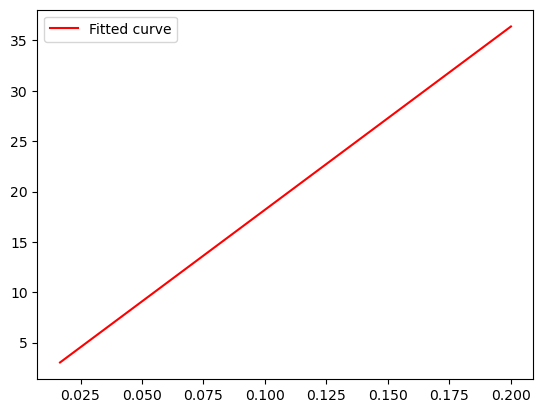

In [ ]:

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def piecewise_func_front(x, a, b, xr):
    return np.where(x <= xr,
                    (a/b) * (1 - np.exp(-b * x)),
                    (a/b) * ((1 - np.exp(-b * xr)) * np.exp(-b * (x - xr))))

# Example data (replace with your real data)
x_data = data['time(hr)']  # Independent variable
y_data = data['Accumulated BKC amount -back- (mg/m3)']  # Dependent variable (replace with real data)

x_data = x_data.dropna()
y_data = y_data.dropna()

# Curve fitting
popt, pcov = curve_fit(piecewise_func_front, x_data, y_data, bounds=(0, [np.inf, np.inf, 5]))

# Extracting fitted parameters
a_fitted, b_fitted, xr_fitted = popt
print("Fitted parameters: a =", a_fitted, "b =", b_fitted, "xr =", xr_fitted)

# Plotting the data and the fit
#plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, piecewise_func_front(x_data, *popt), label='Fitted curve', color='red')
plt.legend()
plt.show()



In [ ]:
import pandas as pd

# Load the Excel file
file_path = r'E:\Root\Chmoinformatics\표면휘발식\2023 ODE\data fitting example.xlsx'

# Read the Excel file to find the names of the sheets
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

# Load the last sheet
last_sheet_name = sheet_names[-1]
last_sheet_data = pd.read_excel(file_path, sheet_name=last_sheet_name)

last_sheet_data.head()



,time (min),Normalization (ug/m^3)
0,1.0,182.176878
1,2.0,237.990262
2,3.0,1130.461284
3,4.0,365.049647
4,5.0,864.946520


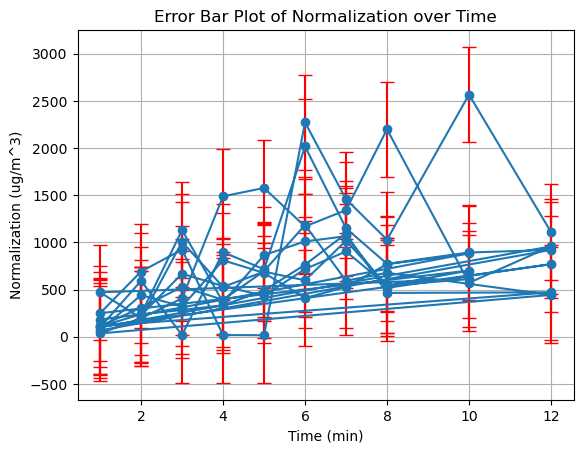

In [ ]:
import matplotlib.pyplot as plt

# Drop NaN values from the dataset
cleaned_data = last_sheet_data.dropna()

# Extracting time and normalization columns
time = cleaned_data['time (min)']
normalization = cleaned_data['Normalization (ug/m^3)']

# Assuming standard deviation for error bars (as no specific error data provided)
# Here, I'm using a placeholder standard deviation.
# Replace with actual error data if available.
std_deviation = normalization.std()

# Creating the error bar plot
plt.errorbar(time, normalization, yerr=std_deviation, fmt='-o', ecolor='red', capsize=5)
plt.xlabel('Time (min)')
plt.ylabel('Normalization (ug/m^3)')
plt.title('Error Bar Plot of Normalization over Time')
plt.grid(True)
plt.show()

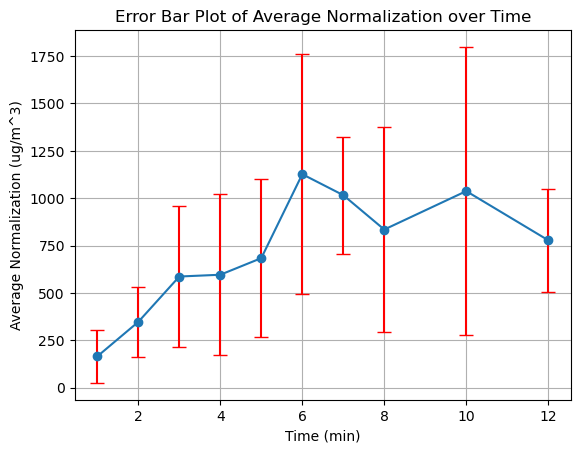

In [ ]:
# Grouping by 'time (min)' and calculating the mean and standard deviation for each group
grouped_data = cleaned_data.groupby('time (min)').agg(['mean', 'std'])
grouped_data.columns = grouped_data.columns.droplevel(0)  # Remove multi-level indexing

# Resetting index to make 'time (min)' a column again
grouped_data = grouped_data.reset_index()

# Extracting time, mean normalization, and standard deviation
time_grouped = grouped_data['time (min)']
mean_normalization = grouped_data['mean']
std_deviation_grouped = grouped_data['std']

# Creating the error bar plot with mean values
plt.errorbar(time_grouped, mean_normalization, yerr=std_deviation_grouped, fmt='-o', ecolor='red', capsize=5)
plt.xlabel('Time (min)')
plt.ylabel('Average Normalization (ug/m^3)')
plt.title('Error Bar Plot of Average Normalization over Time')
plt.grid(True)
plt.show()

In [ ]:
!pip install seaborn

     ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
     ----- ------------------------------- 41.0/294.6 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 294.6/294.6 kB 3.6 MB/s eta 0:00:00


<Figure size 1000x600 with 0 Axes>

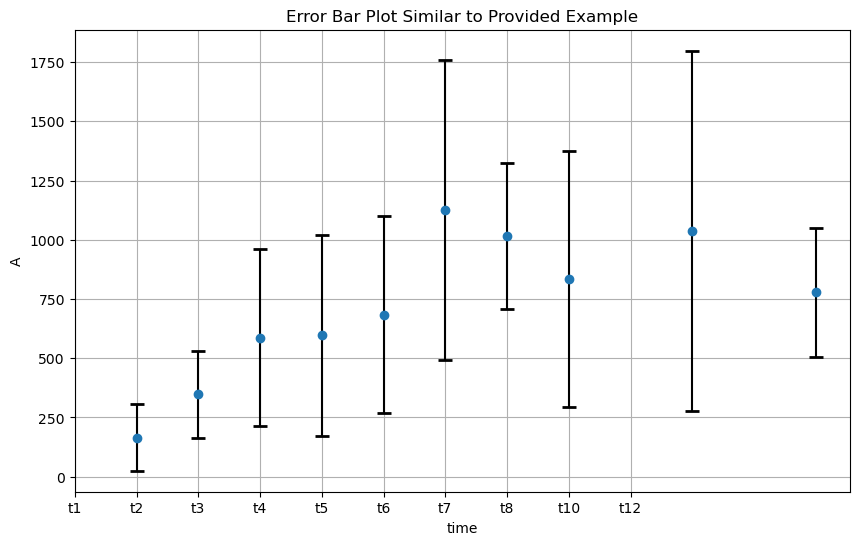

C:\Users\eunwoo\AppData\Local\Temp\ipykernel_24068\3896083284.py:24: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='time (min)', y='Normalization (ug/m^3)', data=cleaned_data,
C:\Users\eunwoo\AppData\Local\Temp\ipykernel_24068\3896083284.py:24: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='time (min)', y='Normalization (ug/m^3)', data=cleaned_data,


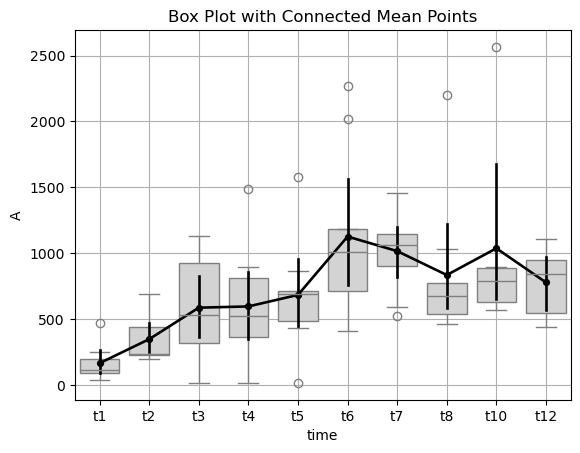

In [ ]:
plt.figure(figsize=(10, 6))
import seaborn as sns

# Calculate mean and standard deviation for each time point
means = cleaned_data.groupby('time (min)')['Normalization (ug/m^3)'].mean()
errors = cleaned_data.groupby('time (min)')['Normalization (ug/m^3)'].std()

# Creating the error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(means.index, means, yerr=errors, fmt='o', ecolor='black', capsize=5, capthick=2)

# Setting the labels and title to match the second plot example provided
plt.xlabel('time')
plt.ylabel('A')
plt.xticks(ticks=range(len(means.index)), labels=['t{}'.format(int(t)) for t in means.index])

plt.title('Error Bar Plot Similar to Provided Example')
plt.grid(True)
plt.show()
# Create a boxplot
sns.boxplot(x='time (min)', y='Normalization (ug/m^3)', data=cleaned_data, color='lightgrey')

# Overlay a point plot which will connect the mean of each boxplot
sns.pointplot(x='time (min)', y='Normalization (ug/m^3)', data=cleaned_data,
              join=True, scale=0.7, color='black')

# Setting the labels and title to match the example provided
plt.xlabel('time')
plt.ylabel('A')
plt.xticks(ticks=range(len(means.index)), labels=['t{}'.format(int(t)) for t in means.index])

plt.title('Box Plot with Connected Mean Points')
plt.grid(True)
plt.show()

C:\Users\eunwoo\AppData\Local\Temp\ipykernel_24068\1605057146.py:7: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='time (min)', y='Normalization (ug/m^3)', data=cleaned_data,
C:\Users\eunwoo\AppData\Local\Temp\ipykernel_24068\1605057146.py:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='time (min)', y='Normalization (ug/m^3)', data=cleaned_data,


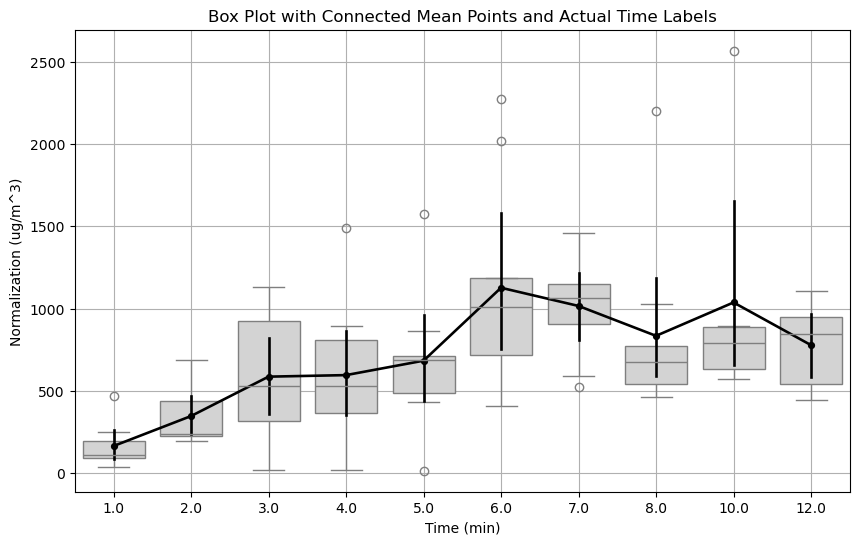

In [ ]:
plt.figure(figsize=(10, 6))

# Create a boxplot
sns.boxplot(x='time (min)', y='Normalization (ug/m^3)', data=cleaned_data, color='lightgrey')

# Overlay a point plot which will connect the mean of each boxplot
sns.pointplot(x='time (min)', y='Normalization (ug/m^3)', data=cleaned_data,
              join=True, scale=0.7, color='black')

# Setting the labels and title to match the example provided
plt.xlabel('Time (min)')
plt.ylabel('Normalization (ug/m^3)')

plt.title('Box Plot with Connected Mean Points and Actual Time Labels')
plt.grid(True)
plt.show()

In [ ]:
df = pd.read_excel(r'E:\Root\Chmoinformatics\표면휘발식\2023 ODE\B7EAF480.xlsx', sheet_name='Sheet3')
df.head()

,time (min),time (hr),Front_auto_Normalization (ug),Front_manual_Normalization (ug),Back_auto_Normalization (ug),Back_auto_Normalization_except0731 (ug),Back_manual_Normalization (ug)
0,1.0,0.016667,0.273265,0.015527,0.109569,0.109569,0.002660
1,2.0,0.033333,0.713971,0.022998,0.103978,0.103978,0.017307
2,3.0,0.050000,5.087076,0.034595,0.398414,0.398414,0.034112
3,4.0,0.066667,NaN,0.049797,0.720545,0.720545,0.038073
4,5.0,0.083333,6.487099,0.075583,1.457803,1.457803,0.184312


In [ ]:
df_front_auto = df[['time (hr)', 'Front_auto_Normalization (ug)']].dropna()
df_front_auto.head()

,time (hr),Front_auto_Normalization (ug)
0,0.016667,0.273265
1,0.033333,0.713971
2,0.050000,5.087076
4,0.083333,6.487099
7,0.133333,6.216456


In [ ]:
#no_nan_df_front_auto = df_front_auto.dropna()
import matplotlib.pyplot as plt
import numpy as np

# Grouping the data by 'Time (hr)' and calculating the mean and standard deviation
front_auto_grouped_data = df_front_auto.groupby('time (hr)').agg(
    ['mean', 'std']).reset_index()
front_auto_grouped_data.to_csv(r'E:\Root\Chmoinformatics\표면휘발식\2023 ODE\front_auto_grouped_data.csv')

In [ ]:
# Extracting the time and mean values
front_auto_time = front_auto_grouped_data['time (hr)']
front_auto_mean = front_auto_grouped_data['Front_auto_Normalization (ug)']['mean']
front_auto_std = front_auto_grouped_data['Front_auto_Normalization (ug)']['std']
front_auto_grouped_data

time (hr) Front_auto_Normalization (ug)          
                                     mean       std
0  0.016667                      0.203729  0.173800
1  0.033333                      0.832292  0.307533
2  0.050000                      2.738346  1.547125
3  0.066667                      3.888863  1.894031
4  0.083333                      4.658116  1.145926
5  0.100000                      6.161596  1.757631
6  0.116667                      7.420889  1.857048
7  0.133333                      6.577824  0.941189
8  0.166667                      8.913440  1.873501
9  0.200000                      7.973607       NaN

In [ ]:
#fitting front_auto_time and front_auto_mean using sigmoid function
from scipy.optimize import curve_fit
def sigmoid(x, L ,x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return (y)

p0 = [1,1,1] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, front_auto_time, front_auto_mean, p0, method='dogbox')

print(popt, pcov)


[ 8.20994134  0.07335247 41.91743546] [[ 2.20189625e-01  1.79048534e-03 -2.23096516e+00]
 [ 1.79048534e-03  2.92932081e-05 -1.78319047e-02]
 [-2.23096516e+00 -1.78319047e-02  6.30851855e+01]]


C:\Users\eunwoo\AppData\Local\Temp\ipykernel_19588\1718695613.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(front_auto_time, front_auto_mean, yerr=front_auto_std,


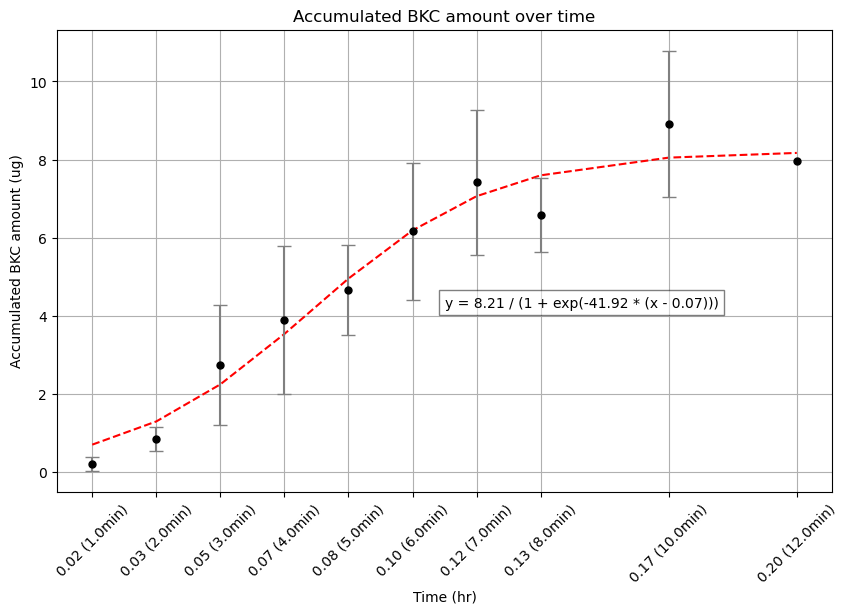

(None, 22.99556896617704)

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(front_auto_time, sigmoid(front_auto_time, *popt), label='Fitted Curve', color='red', linestyle='--')
plt.errorbar(front_auto_time, front_auto_mean, yerr=front_auto_std,
             fmt='o', ecolor='gray', capsize=5, linestyle='', color = 'black', marker='o', markersize=5)

plt.title('Accumulated BKC amount over time')
xticks_labels = [f'{hour:.2f} ({hour*60}min)' for hour in front_auto_time]
plt.xticks(front_auto_time, xticks_labels, rotation=45)
plt.xlabel('Time (hr)')
plt.ylabel('Accumulated BKC amount (μm)')
plt.text(0.5, 0.4, f'y = {popt[0]:.2f} / (1 + exp(-{popt[2]:.2f} * (x - {popt[1]:.2f})))',
            transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)

# Calculating the area of the error bars
error_bar_area = np.sum(front_auto_std * 2)  # Multiply by 2 for both sides of the mean

plt.show(), error_bar_area

In [ ]:
df_back_auto = df[['time (hr)', 'Back_auto_Normalization (ug)']].dropna()
df_back_auto.head()

,time (hr),Back_auto_Normalization (ug)
0,0.016667,0.109569
1,0.033333,0.103978
2,0.050000,0.398414
3,0.066667,0.720545
4,0.083333,1.457803


In [ ]:
back_auto_grouped_data = df_back_auto.groupby('time (hr)').agg(
    ['mean', 'std']).reset_index()
back_auto_grouped_data.to_csv(r'E:\Root\Chmoinformatics\표면휘발식\2023 ODE\back_auto_grouped_data.csv')

In [ ]:
back_auto_grouped_data.index

RangeIndex(start=0, stop=15, step=1)

In [ ]:
index_to_drop = back_auto_grouped_data.index[-2]

# Drop the second-to-last row
back_auto_grouped_data_edit = back_auto_grouped_data.drop([9, 13, 14])

back_auto_grouped_data_edit

time (hr) Back_auto_Normalization (ug)          
                                     mean       std
0   0.000000                     0.203568       NaN
1   0.016667                     0.166409  0.156001
2   0.033333                     0.239988  0.246335
3   0.050000                     0.484861  0.278054
4   0.066667                     0.752284  0.325246
5   0.083333                     1.181030  0.998005
6   0.100000                     1.660646  0.489146
7   0.116667                     0.976523  0.575506
8   0.133333                     1.460068  0.930555
10  0.166667                     1.835193  0.275477
11  0.183333                     0.998055       NaN
12  0.200000                     1.103384  0.391837

[1.34817681e+00 5.77735042e-02 6.72790817e+01] [[ 1.74394054e-02  5.73676944e-04 -1.97855315e+00]
 [ 5.73676944e-04  8.78733396e-05 -6.47219518e-02]
 [-1.97855315e+00 -6.47219518e-02  1.32817073e+03]]


C:\Users\eunwoo\AppData\Local\Temp\ipykernel_19588\1567456671.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(back_auto_time, back_auto_mean, yerr=back_auto_std,


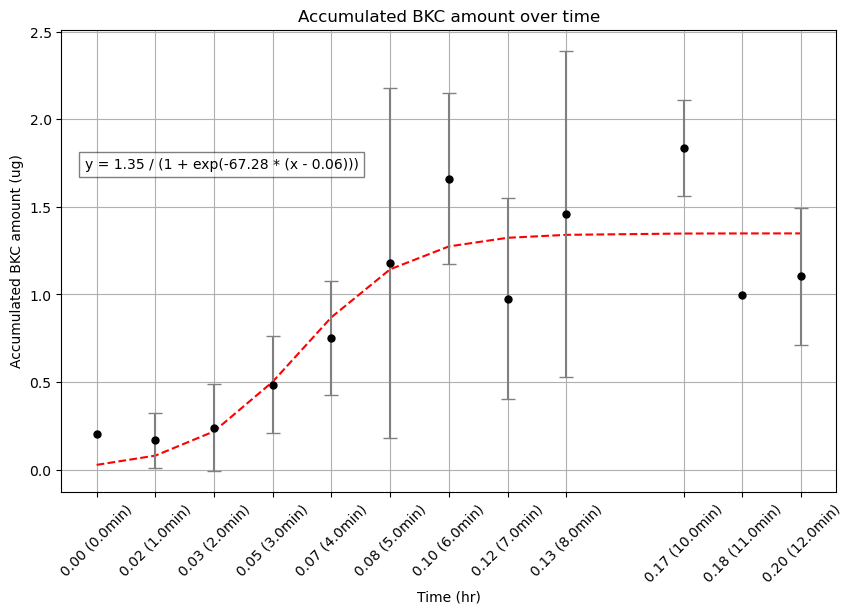

(None, 9.332322933079757)

In [ ]:
# Extracting the time and mean values
back_auto_time = back_auto_grouped_data_edit['time (hr)']
back_auto_mean = back_auto_grouped_data_edit['Back_auto_Normalization (ug)']['mean']
back_auto_std = back_auto_grouped_data_edit['Back_auto_Normalization (ug)']['std']

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def sigmoid(x, L ,x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return (y)

p0 = [1,1,1] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, back_auto_time, back_auto_mean, p0, method='dogbox')

print(popt, pcov)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(back_auto_time, sigmoid(back_auto_time, *popt), label='Fitted Curve', color='red', linestyle='--')
plt.errorbar(back_auto_time, back_auto_mean, yerr=back_auto_std,
             fmt='o', ecolor='gray', capsize=5, linestyle='', color = 'black', marker='o', markersize=5)

plt.title('Accumulated BKC amount over time')
xticks_labels = [f'{hour:.2f} ({hour*60}min)' for hour in back_auto_time]
plt.xticks(back_auto_time, xticks_labels, rotation=45)
plt.xlabel('Time (hr)')
plt.ylabel('Accumulated BKC amount (μm)')
plt.text(0.03, 0.7, f'y = {popt[0]:.2f} / (1 + exp(-{popt[2]:.2f} * (x - {popt[1]:.2f})))',
            transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)

# Calculating the area of the error bars
error_bar_area = np.sum(back_auto_std * 2)  # Multiply by 2 for both sides of the mean

plt.show(), error_bar_area

In [ ]:
# modify xlabel in the plot


In [ ]:
df_back_auto_except = df[['time (hr)', 'Back_auto_Normalization_except0731 (ug)']].dropna()
df_back_auto_except.head()

,time (hr),Back_auto_Normalization_except0731 (ug)
0,0.016667,0.109569
1,0.033333,0.103978
2,0.050000,0.398414
3,0.066667,0.720545
4,0.083333,1.457803


In [ ]:
back_auto_except_grouped_data = df_back_auto_except.groupby('time (hr)').agg(
    ['mean', 'std']).reset_index()
back_auto_except_grouped_data.to_csv(r'E:\Root\Chmoinformatics\표면휘발식\2023 ODE\back_auto_except_grouped_data.csv')

In [ ]:
back_auto_except_grouped_data.head()

time (hr) Back_auto_Normalization_except0731 (ug)          
                                               mean       std
0  0.016667                                0.097465  0.027567
1  0.033333                                0.118384  0.047914
2  0.050000                                0.514147  0.312038
3  0.066667                                0.617083  0.221363
4  0.083333                                1.181030  0.998005

[1.40017143e+00 6.30948315e-02 7.09394328e+01] [[ 2.84573273e-02  8.52399817e-04 -3.28161012e+00]
 [ 8.52399817e-04  1.01151096e-04 -9.69282112e-02]
 [-3.28161012e+00 -9.69282112e-02  1.88752770e+03]]


C:\Users\eunwoo\AppData\Local\Temp\ipykernel_24068\1147701561.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(back_auto_except_time, back_auto_except_mean, yerr=back_auto_except_std,


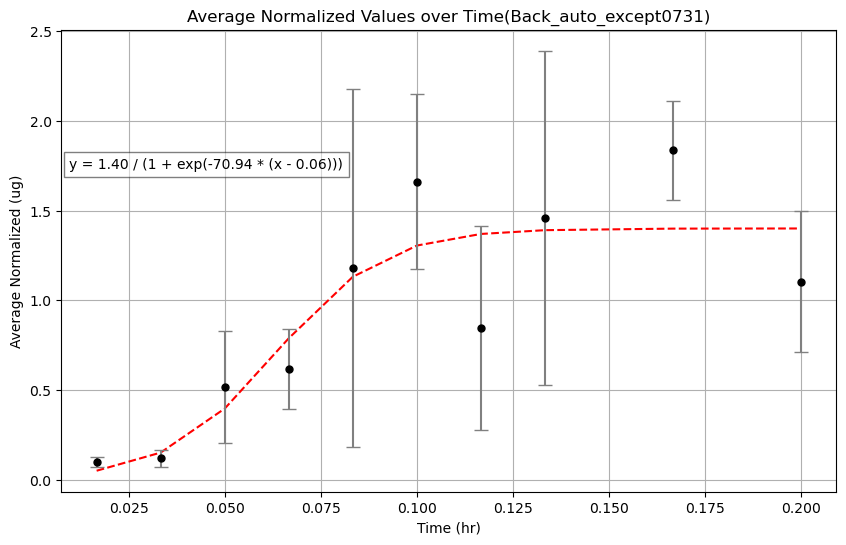

(None, 8.524591296692657)

In [ ]:
# Extracting the time and mean values
back_auto_except_time = back_auto_except_grouped_data['time (hr)']
back_auto_except_mean = back_auto_except_grouped_data['Back_auto_Normalization_except0731 (ug)']['mean']
back_auto_except_std = back_auto_except_grouped_data['Back_auto_Normalization_except0731 (ug)']['std']

def sigmoid(x, L ,x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return (y)

p0 = [1,1,1] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, back_auto_except_time, back_auto_except_mean, p0, method='dogbox')

print(popt, pcov)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(back_auto_except_time, sigmoid(back_auto_except_time, *popt), label='Fitted Curve', color='red', linestyle='--')
plt.errorbar(back_auto_except_time, back_auto_except_mean, yerr=back_auto_except_std,
             fmt='o', ecolor='gray', capsize=5, linestyle='', color = 'black', marker='o', markersize=5)

plt.title('Average Normalized Values over Time(Back_auto_except0731)')
plt.xlabel('Time (hr)')
plt.ylabel('Average Normalized (ug)')
plt.text(0.01, 0.7, f'y = {popt[0]:.2f} / (1 + exp(-{popt[2]:.2f} * (x - {popt[1]:.2f})))',
            transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)

# Calculating the area of the error bars
error_bar_area = np.sum(back_auto_except_std * 2)  # Multiply by 2 for both sides of the mean

plt.show(), error_bar_area

In [ ]:
df_front_manual = df[['time (hr)', 'Front_manual_Normalization (ug)']].dropna()
df_front_manual.head()

,time (hr),Front_manual_Normalization (ug)
0,0.016667,0.015527
1,0.033333,0.022998
2,0.050000,0.034595
3,0.066667,0.049797
4,0.083333,0.075583


In [ ]:
# Grouping the data by 'Time (hr)' and calculating the mean and standard deviation
front_manual_grouped_data = df_front_manual.groupby('time (hr)').agg(
    ['mean', 'std']).reset_index()
front_manual_grouped_data.to_csv(r'E:\Root\Chmoinformatics\표면휘발식\2023 ODE\front_manual_grouped_data.csv')

[ 0.13856146  0.06852983 34.17525082] [[ 8.72510217e-05  4.93895218e-05 -4.41924145e-02]
 [ 4.93895218e-05  4.83802137e-05 -2.35658814e-02]
 [-4.41924145e-02 -2.35658814e-02  5.08276432e+01]]


C:\Users\eunwoo\AppData\Local\Temp\ipykernel_19588\563641818.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(front_manual_time, front_manual_mean, yerr=front_manual_std,


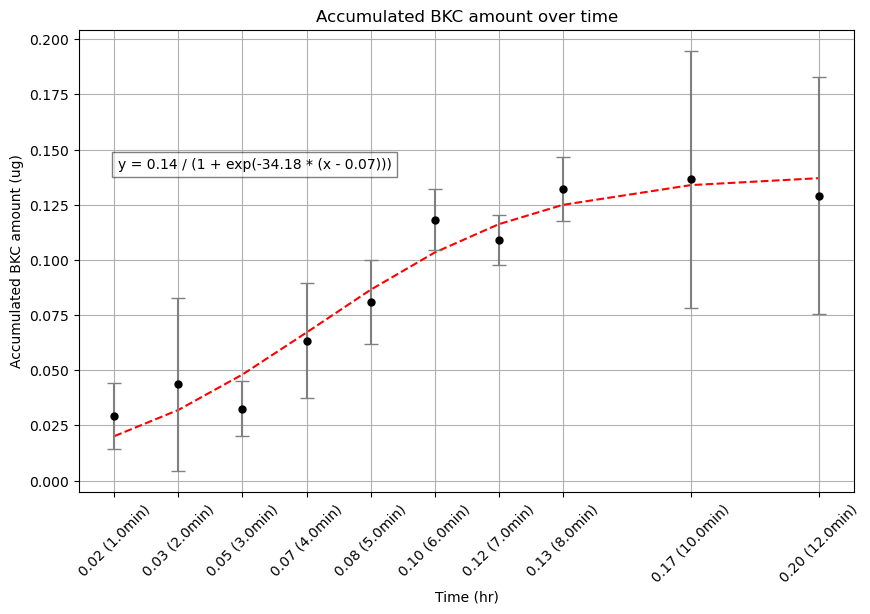

(None, 0.5264780354650601)

In [ ]:
# Extracting the time and mean values
front_manual_time = front_manual_grouped_data['time (hr)']
front_manual_mean = front_manual_grouped_data['Front_manual_Normalization (ug)']['mean']
front_manual_std = front_manual_grouped_data['Front_manual_Normalization (ug)']['std']

def sigmoid(x, L ,x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return (y)

p0 = [1,1,1] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, front_manual_time, front_manual_mean, p0, method='dogbox')

print(popt, pcov)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(front_manual_time, sigmoid(front_manual_time, *popt), label='Fitted Curve', color='red', linestyle='--')
plt.errorbar(front_manual_time, front_manual_mean, yerr=front_manual_std,
             fmt='o', ecolor='gray', capsize=5, linestyle='', color = 'black', marker='o', markersize=5)

plt.title('Accumulated BKC amount over time')
xticks_labels = [f'{hour:.2f} ({hour*60}min)' for hour in front_manual_time]
plt.xticks(front_manual_time, xticks_labels, rotation=45)
plt.xlabel('Time (hr)')
plt.ylabel('Accumulated BKC amount (μg)')
plt.text(0.05, 0.7, f'y = {popt[0]:.2f} / (1 + exp(-{popt[2]:.2f} * (x - {popt[1]:.2f})))',
            transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)
plt.grid(True)

# Calculating the area of the error bars
error_bar_area = np.sum(front_manual_std * 2)  # Multiply by 2 for both sides of the mean

plt.show(), error_bar_area

In [ ]:
df_back_manual = df[['time (hr)', 'Back_manual_Normalization (ug)']].dropna()
df_back_manual.head()

,time (hr),Back_manual_Normalization (ug)
0,0.016667,0.002660
1,0.033333,0.017307
2,0.050000,0.034112
3,0.066667,0.038073
4,0.083333,0.184312


In [ ]:
# Grouping the data by 'Time (hr)' and calculating the mean and standard deviation
back_manual_grouped_data = df_back_manual.groupby('time (hr)').agg(
    ['mean', 'std']).reset_index()
back_manual_grouped_data.to_csv(r'E:\Root\Chmoinformatics\표면휘발식\2023 ODE\back_manual_grouped_data.csv')

[ 0.29448988  0.07684358 41.11459982] [[ 1.13026009e-04  2.60017448e-05 -3.03117390e-02]
 [ 2.60017448e-05  1.15093348e-05 -6.96046465e-03]
 [-3.03117390e-02 -6.96046465e-03  2.22506884e+01]]


C:\Users\eunwoo\AppData\Local\Temp\ipykernel_19588\1512546168.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(back_manual_time, back_manual_mean, yerr=back_manual_std,


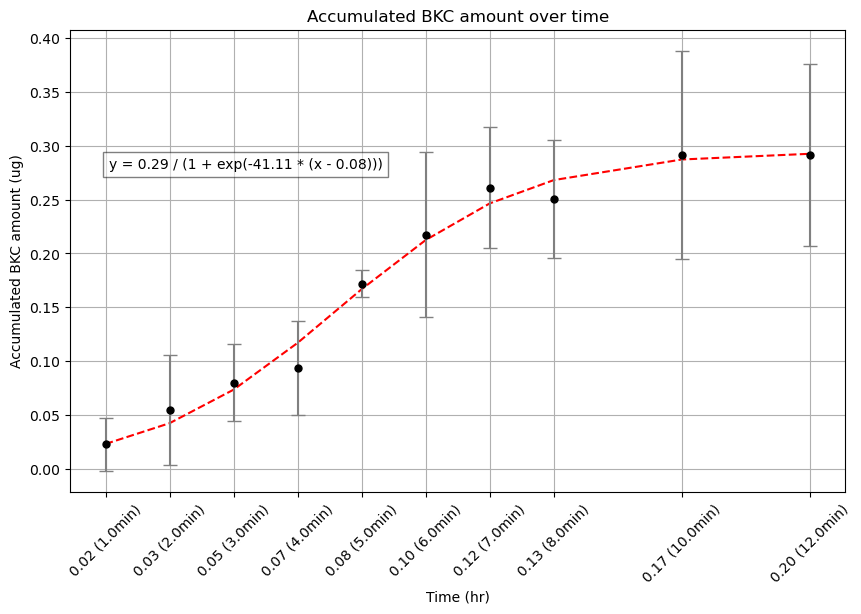

(None, 1.074348381864456)

In [ ]:
# Extracting the time and mean values
back_manual_time = back_manual_grouped_data['time (hr)']
back_manual_mean = back_manual_grouped_data['Back_manual_Normalization (ug)']['mean']
back_manual_std = back_manual_grouped_data['Back_manual_Normalization (ug)']['std']

def sigmoid(x, L ,x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return (y)

p0 = [1,1,1] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, back_manual_time, back_manual_mean, p0, method='dogbox')

print(popt, pcov)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(back_manual_time, sigmoid(back_manual_time, *popt), label='Fitted Curve', color='red', linestyle='--')
plt.errorbar(back_manual_time, back_manual_mean, yerr=back_manual_std,
             fmt='o', ecolor='gray', capsize=5, linestyle='', color = 'black', marker='o', markersize=5)

plt.title('Accumulated BKC amount over time')
xticks_labels = [f'{hour:.2f} ({hour*60}min)' for hour in back_manual_time]
plt.xticks(back_manual_time, xticks_labels, rotation=45)
plt.xlabel('Time (hr)')
plt.ylabel('Accumulated BKC amount (μg)')
plt.text(0.05, 0.7, f'y = {popt[0]:.2f} / (1 + exp(-{popt[2]:.2f} * (x - {popt[1]:.2f})))',
            transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)

# Calculating the area of the error bars
error_bar_area = np.sum(back_manual_std * 2)  # Multiply by 2 for both sides of the mean

plt.show(), error_bar_area

In [ ]:
scatter_df = pd.read_excel('/content/drive/MyDrive/ODE/231212data.xlsx', sheet_name='Sheet4')

scatter_df

,분사시간(min),공간체적당 포집량(ug/m^3)
0,1,NaN
1,2,594.280055
2,3,950.687744
3,4,1293.583958
4,5,1420.571980
5,6,1235.649881
6,7,875.000541
7,8,533.370267
8,10,451.655586
9,12,119.752319


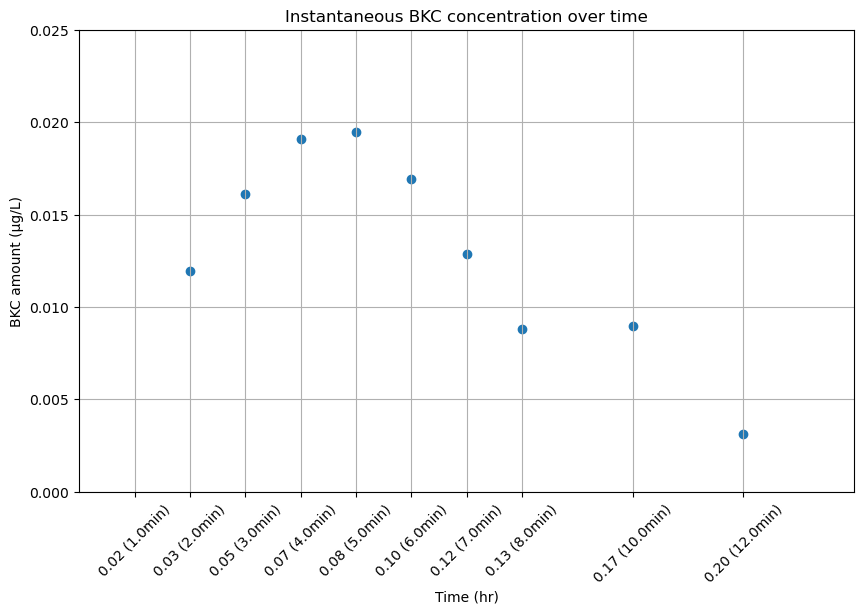

In [ ]:
#draw scatter plot with scatter_df
import matplotlib.pyplot as plt
import numpy as np

time = scatter_df['분사시간(min)']/60

plt.figure(figsize=(10, 6))
plt.scatter(time, scatter_df['공간체적당 포집량(ug/m^3)']/1000)
plt.title('Instantaneous BKC concentration over time')
xticks_labels = [f'{hour:.2f} ({hour*60}min)' for hour in time]
plt.xticks(time, xticks_labels, rotation=45)
plt.xlabel('Time (hr)')
plt.ylabel('BKC amount (μg/L)')
plt.xlim(0, 14/60)
plt.ylim(0, 0.025)
plt.grid(True)
plt.show()